In [30]:
# Install external libraries

# pip install lion-pytorch
# pip install torch-summary

In [31]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import time
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

from torchsummary import summary
from lion_pytorch import Lion

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Check cuda version in cmd
# nvcc --version
# Check GPU in cmd
# nvidia-smi

In [32]:
# Setup device-agnostic code
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [33]:
print("PyTorch version:", torch.__version__)
print(torch.cuda.get_device_name(0))

PyTorch version: 2.0.1
NVIDIA GeForce GTX 1050 Ti


In [34]:
# GOOGLE COLAB

# Import dataset from gdrive

# from google.colab import drive
# drive.mount('/content/drive')
# !pwd

# Open one image from the dataset (Google Colab)

# path = "drive/My Drive/Master/dataset/"
# with Image.open(path + 'frost/3600.jpg') as img:
#     print("\t")
#     display(img)

In [35]:
# Set the random seed for CPU operations
seed = 16
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Check if CUDA is available and set the random seed for GPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

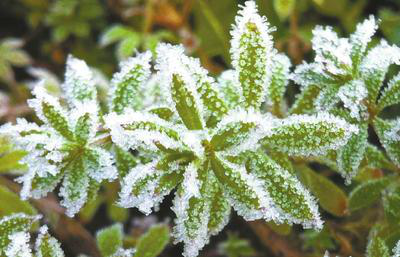

In [36]:
# Open one image from the dataset (Locally)
path = 'dataset'
with Image.open(path + '/frost/3600.jpg') as img:
    display(img)

In [37]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(path, transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset

In [38]:
# Display number of classes in the dataset
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


## Convert dataset into CSV file

In [39]:
# List to store image paths and corresponding labels
data = []

# Loop through each label directory
for label_name in os.listdir(path):
    label_dir = os.path.join(path, label_name)
    if os.path.isdir(label_dir):
        # Loop through each image file in the label directory
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                label = label_name
                data.append((image_path, label))

# Convert the data list into a Pandas DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Save the DataFrame to a CSV file
csv_file = 'dataset.csv'  # Change the filename if desired
df.to_csv(csv_file, index=False)

In [40]:
# Load csv file and show first 5 rows
df = pd.read_csv('dataset.csv')
df.head() 

,image_path,label
0,dataset\dew\2208.jpg,dew
1,dataset\dew\2209.jpg,dew
2,dataset\dew\2210.jpg,dew
3,dataset\dew\2211.jpg,dew
4,dataset\dew\2212.jpg,dew


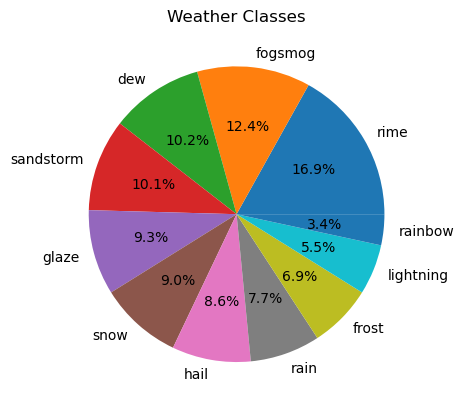

In [41]:
# Plot a pie chart to visualize % of each class in the dataset
label_counts = df["label"].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Weather Classes')
plt.show()

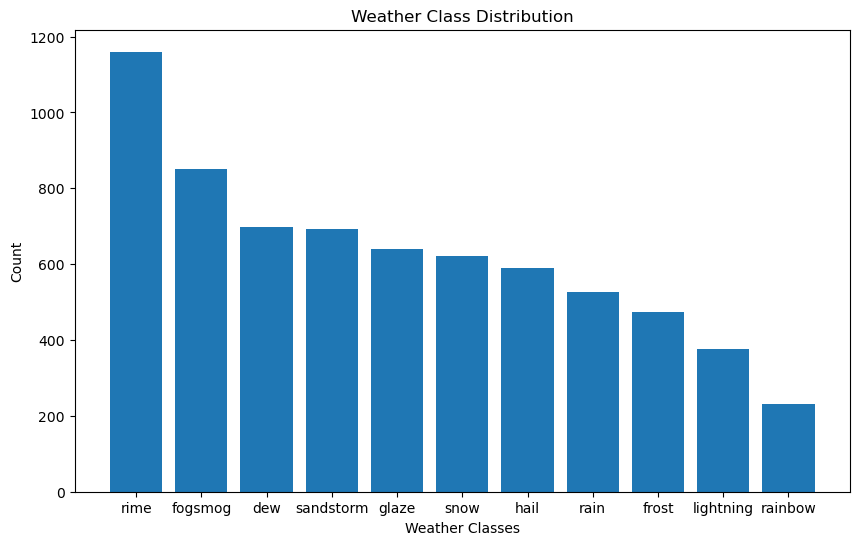

In [42]:
# Plot a bar chart to visualize the count of each class in the dataset
label_counts = df["label"].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts)
plt.xlabel('Weather Classes')
plt.ylabel('Count')
plt.title('Weather Class Distribution')
plt.show()

## Split dataset into train, validation and test sets

In [43]:
# Split dataset into train and test
train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
val_size = len(train_data_old) - train_size
train_data, val_data = torch.utils.data.random_split(train_data_old, [train_size, val_size])

## Define transforms for each set

In [44]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training set transformations
train_transform = transforms.Compose([
#     transforms.Resize((300,300)),
#     transforms.RandomResizedCrop((224,224)),
    transforms.Resize((440,440)),
    transforms.RandomResizedCrop((384,384)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 3.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

# Validation set transformations
val_transform = transforms.Compose([
#     transforms.Resize((300,300)),
#     transforms.CenterCrop((224,224)),    
    transforms.Resize((384,384)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_data.dataset.transform = val_transform

# Test set transformations
test_transform = transforms.Compose([
#     transforms.Resize((300,300)),
#     transforms.CenterCrop((224,224)),    
    transforms.Resize((384,384)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

## Create initial data loaders for each set of data

In [45]:
# Define initial batch size, before hyperparameter tuning
batch = 128

# Define initial Data loaders, before hyperparameter tuning
train_loader = DataLoader(train_data, batch_size=batch, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch, pin_memory=True, shuffle=False)

# Define variables for sizes of each set
train_data_len = len(train_data)
val_data_len = len(val_data)
test_data_len = len(test_data)

print("Training images available:", train_data_len)
print("\t")
print("Validation images available:", val_data_len)
print("\t")
print("Testing images available:", test_data_len)

Training images available: 4957
	
Validation images available: 875
	
Testing images available: 1030


In [46]:
# Print Tensor shape
print(train_data[0][0].shape)

print("\t")
# Print one Tensor label pair
print(train_data[0])

torch.Size([3, 384, 384])
	
(tensor([[[-1.6213, -1.6384, -1.6384,  ..., -1.4500, -1.4672, -1.4329],
         [-1.6384, -1.6384, -1.6555,  ..., -1.4672, -1.4672, -1.4158],
         [-1.6213, -1.6384, -1.6384,  ..., -1.4672, -1.4672, -1.4329],
         ...,
         [-1.5185, -1.5870, -1.6384,  ..., -1.0048, -1.0219, -1.0390],
         [-1.5528, -1.6042, -1.6727,  ..., -1.0219, -1.0390, -1.0562],
         [-1.6042, -1.6213, -1.6898,  ..., -1.0390, -1.0733, -1.1075]],

        [[-1.2654, -1.2829, -1.2829,  ..., -1.0203, -1.0203, -0.9503],
         [-1.2829, -1.2829, -1.3004,  ..., -1.0203, -1.0028, -0.9503],
         [-1.2654, -1.2829, -1.2829,  ..., -1.0203, -1.0203, -0.9678],
         ...,
         [-1.1779, -1.2654, -1.3179,  ..., -0.4251, -0.4601, -0.4776],
         [-1.2129, -1.3004, -1.3529,  ..., -0.4251, -0.4601, -0.4776],
         [-1.2654, -1.3354, -1.3880,  ..., -0.4251, -0.4426, -0.4601]],

        [[-1.6127, -1.6302, -1.6302,  ..., -1.6999, -1.7173, -1.6999],
         [-1.630

Class Indexes:
['frost', 'rime', 'hail', 'sandstorm', 'fogsmog', 'fogsmog', 'lightning', 'sandstorm', 'rime', 'hail', 'snow', 'dew', 'fogsmog', 'frost', 'hail', 'lightning']
	


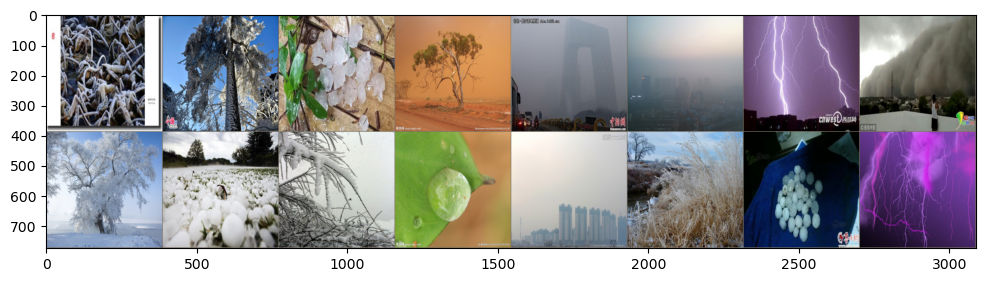

In [47]:
# Grab the first batch of images
for images, labels in train_loader: 
    break
    
# Extract the first 16 images
images_subset = images[:16]
labels_subset = labels[:16]

class_index_to_label = {
    0: 'dew',
    1: 'fogsmog',
    2: 'frost',
    3: 'glaze',
    4: 'hail',
    5: 'lightning',
    6: 'rain',
    7: 'rainbow',
    8: 'rime',
    9: 'sandstorm',
    10: 'snow'
}

# Map indexes to labels
labels = [class_index_to_label[i] for i in labels_subset.numpy()]

# Print the labels
print('Class Indexes:')
print(labels)
print("\t")

# Make a grid with 8 images in each row
im = make_grid(images_subset, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Define functions

## Count number of trainable parameters

In [48]:
def count_parameters(model):
    print("Total sum of trainable weights in the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

## Move model and optimizer to GPU

In [49]:
def move_model_and_optimizer_to_gpu(model, optimizer):
    
    # Move model to device
    model.to(device)
    next(model.parameters()).is_cuda
    
    # Move optimizer to device
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

## Hyperparameter tuning

In [50]:
def hyperparameter_tuning(model, learning_rates, batch_sizes, l1_lambdas, l2_lambdas, model_name, optimizer_name):

    start_time = time.time()
    
    model_name = model_name
    optimizer_name = optimizer_name

    best_lr = None
    best_batch_size = None
    best_l1 = None
    best_l2 = None
    best_accuracy = 0.0
    epochs = 200

    
    # Define hyperparameter loops
    for lr in learning_rates:
        for batch in batch_sizes:
            for l1 in l1_lambdas:
                for l2 in l2_lambdas:
                    
                    # Set train and val loaders for different batch values
                    train_loader = DataLoader(train_data, batch_size=batch, pin_memory=True, shuffle=True)
                    val_loader = DataLoader(val_data, batch_size=batch, pin_memory=True, shuffle=False)

                    
                    # Check which model is going to be used
                    if model_name == "ShuffleNet":
                        model = models.shufflenet_v2_x2_0(pretrained=True)
                        for param in model.parameters():
                            param.requires_grad = False
                        model.fc = nn.Linear(2048, 11)
                        
                        # Check which optimizer is going to be used
                        if optimizer_name == "AdamW":
                            # Set different learning rates and l2 lambdas for optimizer
                            optimizer = torch.optim.AdamW(model.fc.parameters(), lr=lr, weight_decay=l2)
                            
                        elif optimizer_name == "SGD":
                            optimizer = torch.optim.SGD(model.fc.parameters(), lr=lr, weight_decay=l2)
                            
                        elif optimizer_name == "Lion":
                            optimizer = Lion(model.fc.parameters(), lr=lr, weight_decay=l2)
                            
                        else:
                            return print("Optimizer name does not match")
                        
                    else:
                        return print("Model name does not match")
                        

                    criterion = nn.CrossEntropyLoss()       

                    # Move optimizer state to the GPU
                    move_model_and_optimizer_to_gpu(model, optimizer)

                    print("\t")
                    print(f"Training {model_name} with Optimizer: {optimizer_name}, Learning Rate:", lr,
                          ", Batch Size:", batch, ", L1:", l1, ", L2:", l2)
                    print("--------------------------------------------------------------------------------------------------")


                    # Define patience, counter, best validation accuracy and
                    # a boolean value that determines if early stop mechanism is to be activated
                    patience = 10
                    counter = 0
                    best_val_acc = 0
                    best_train_acc = 0.0
                    is_early_stop = False

                    # For each epoch run the training and validation bathes
                    for epoch in range(epochs):
                        train_corr = 0
                        val_corr = 0

                        # Run the training batches
                        model.train()
                        
                        for images, labels in train_loader:

                            # Move images and labels to device
                            images = images.to(device)
                            labels = labels.to(device)

                            # Apply the model for training
                            outputs = model(images)
                            # Number of losses
                            loss = criterion(outputs, labels)

                            # Number of correct predictions
                            predicted = torch.max(outputs.data, 1)[1]
                            train_corr += (predicted == labels).sum()
                            
                            # L1 regularization term calculation
                            l1_reg = torch.tensor(0.).to(device)
                            for param in model.fc.parameters():
                                l1_reg += torch.norm(param, p=1)

                            # Calculate the total loss with L1 regularization
                            total_loss = loss + l1 * l1_reg

                            # Update parameters during training
                            optimizer.zero_grad()
                            total_loss.backward()
                            optimizer.step()

                        # Calculate accuracy after each epoch
                        accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)
                        
                        # Update best training accuracy if higher
                        if accuracy_train > best_train_acc:
                            best_train_acc = accuracy_train                        



                        # Run the validation batches
                        model.eval()

                        with torch.no_grad():
                            for images, labels in val_loader:

                                # Move images and labels to device
                                images = images.to(device)
                                labels = labels.to(device)

                                # Apply the model for validation
                                outputs = model(images)
                                # Number of losses
                                loss = criterion(outputs, labels)

                                # Number of correct predictions
                                predicted = torch.max(outputs.data, 1)[1] 
                                val_corr += (predicted == labels).sum()

                            # Calculate accuracy after each epoch
                            accuracy_val = round(val_corr.item() * 100 / val_data_len, 3)    
                            


                            # Early stopping
                            if accuracy_val > best_val_acc:
                                best_val_acc = accuracy_val
                                counter = 0
                            else:
                                counter += 1

                            # Check for early stopping after the validation loop    
                            if counter >= patience:
                                is_early_stop = True           
                                print("Early stopping triggered. Training stopped at epoch:", epoch + 1)
                                break


                        if is_early_stop:
                            break

     
                    print("For current Hyperparameter combination, best Training Accuracy is:", best_train_acc,
                      "% and best Validation Accuracy is:", best_val_acc, "%")
        
                            
                    # Check if the current hyperparameters achieved better accuracy
                    if best_val_acc > best_accuracy:
                        best_accuracy = best_val_acc
                        best_lr = lr
                        best_batch_size = batch
                        best_l1 = l1
                        best_l2 = l2
                        print("Current best Hyperparameters: Learning Rate:", best_lr, "Batch Size:", best_batch_size,
                              "L1:", best_l1, "L2:", best_l2, "Validation accuracy:", best_accuracy, "%")


    print("\n")
    print("Best Hyperparameters overall: Learning Rate:", best_lr, "Batch Size:", best_batch_size,
          "L1:", best_l1, "L2:", best_l2,"Validation accuracy:", best_accuracy, "%")
    print("\t")
    print("Duration:", round(time.time() - start_time, 1), "seconds")
    
    return best_lr, best_batch_size, best_l1, best_l2

## Set the best hyperparameters

In [51]:
def set_best_hyperparameters(model, batch_size, learning_rate, l1_lambda, l2_lambda, optimizer_name):
    
    optimizer_name = optimizer_name
    
    # Set the best hyperparameters
    batch_size = batch_size
    learning_rate = learning_rate
    l1_lambda = l1_lambda
    l2_lambda = l2_lambda

    # Define Data Loaders with the best hyperparameters
    train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, pin_memory=True, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    
    # Define optimizer with the best hyperparameters
    if optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.fc.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    elif optimizer_name == "Lion":
        optimizer = Lion(model.fc.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    else:
        return print("Optimizer name does not match")
        
    return train_loader, val_loader, test_loader, criterion, optimizer

## Train and validate model

In [52]:
def train_and_val_model(model, criterion, optimizer, l1_lambda, train_loader, val_loader, model_name,
                        train_loss_list, train_corr_list, val_loss_list, val_corr_list, optimizer_name):
    
    start_time = time.time()
    # Number of epochs
    epochs = 200
    
    model_name = model_name
    optimizer_name = optimizer_name

    # Define patience, counter, best validation accuracy and
    # a boolean value that determines if early stop mechanism is to be activated
    patience = 10
    counter = 0
    best_val_acc = 0
    is_early_stop = False


    # For each epoch run the training and validation bathes
    for epoch in range(epochs):
        train_corr = 0
        val_corr = 0

        # Run the training batches
        model.train()
        
        for images, labels in train_loader:

            # Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for training
            outputs = model(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # Number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            train_corr += (predicted == labels).sum()
            
            # L1 regularization term calculation
            l1_reg = torch.tensor(0.).to(device)
            for param in model.fc.parameters():
                l1_reg += torch.norm(param, p=1)

            # Calculate the total loss with L1 regularization
            total_loss = loss + l1_lambda * l1_reg

            # Update parameters during training
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        # Append losses and correct predictions per epoch
        train_loss_list.append(loss)
        train_corr_list.append(train_corr)

        # Calculate accuracy after each epoch
        accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)

        # Print each epoch results
        print("Epoch:", epoch + 1, "Train Loss:", round(loss.item(), 3),
              "Train Accuracy:", accuracy_train, "%")




        # Run the validation batches
        model.eval()

        with torch.no_grad():
            for images, labels in val_loader:

                # Move images and labels to device
                images = images.to(device)
                labels = labels.to(device)

                # Apply the model for validation
                outputs = model(images)
                # Number of losses
                loss = criterion(outputs, labels)

                # Number of correct predictions
                predicted = torch.max(outputs.data, 1)[1]
                val_corr += (predicted == labels).sum()

            # Calculate accuracy after each epoch
            accuracy_val = round(val_corr.item() * 100 / val_data_len, 3)



            # Early stopping
            if accuracy_val > best_val_acc:
                best_val_acc = accuracy_val
                counter = 0

                if optimizer_name == "AdamW":
                    # Save model with best accuracy
                    torch.save(model.state_dict(), f"{model_name}AdamW.pt")
                    
                elif optimizer_name == "Lion":
                    torch.save(model.state_dict(), f"{model_name}Lion.pt")
                    
                elif optimizer_name == "SGD":
                    torch.save(model.state_dict(), f"{model_name}SGD.pt")
                
            else:
                counter += 1

            # Check for early stopping after the validation loop
            if counter >= patience:
                is_early_stop = True
                print("Epoch:", epoch + 1, "Validation Loss:", round(loss.item(), 3),
                      "Validation Accuracy:", accuracy_val, "%")
                print("Early stopping triggered. Training stopped.")
                break


        # Append losses and correct predictions per epoch
        val_loss_list.append(loss)
        val_corr_list.append(val_corr)

        if is_early_stop:
            break
        else:
            # Print each epoch results
            print("Epoch:", epoch + 1, "Validation Loss:", round(loss.item(), 3),
                  "Validation Accuracy:", accuracy_val, "%")
            print("Best Validation Accuracy:", round(best_val_acc, 3), "% counter:", counter)
            print("\t")


    print("\n")
    print("Duration:", round(time.time() - start_time, 1), "seconds")

## Test model

In [53]:
def test_model(model_best, criterion, test_loader, test_corr_list):

    global accuracy_global
    test_corr = 0

    # Run the test batches
    model_best.eval()

    with torch.no_grad():
        for images, labels in test_loader:

            # Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for validation
            outputs = model_best(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # Number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            test_corr += (predicted == labels).sum()

        # Calculate accuracy
        accuracy = round(test_corr.item() * 100 / test_data_len, 3)

    test_corr_list.append(test_corr)
    
    return accuracy

## Confusion Matrix

In [54]:
def show_confusion_matrix(model_best):
    
    # Create a loader for the entire test set
    test_load_all = DataLoader(test_data, batch_size=test_data_len, shuffle=False)
    
    # Move model to cpu
    model_best.cpu()

    with torch.no_grad():
        
        correct = 0
        predicted_labels = []
        true_labels = []
        
        for images, labels in test_load_all:

            # Move images and labels to cpu
            images = images.cpu()
            labels = labels.cpu()

            outputs = model_best(images)
            predicted = torch.max(outputs, 1)[1]
            correct += (predicted == labels).sum()
            
            # Append predicted and true labels to lists
            predicted_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    arr = confusion_matrix(true_labels, predicted_labels)
    df_cm = pd.DataFrame(arr, classes, classes)
    
    # Call cm_metrics function to calculate confusion matrix metrics
    cm_metrics(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize = (9,6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show();

## Calculate Confusion Matrix metrics

In [55]:
def cm_metrics(true, predicted):

    TP = {}
    FP = {}
    TN = {}
    FN = {}

    for class_label in range(len(classes)):
        TP[class_label] = 0
        FP[class_label] = 0
        TN[class_label] = 0
        FN[class_label] = 0

    for i in range(len(predicted)):
        if true[i] == predicted[i]:
            TP[true[i]] += 1
            for class_label in range(len(classes)):
                if class_label != true[i]:
                    TN[class_label] += 1
        else:
            FP[predicted[i]] += 1
            FN[true[i]] += 1
            for class_label in range(len(classes)):
                if class_label != true[i] and class_label != predicted[i]:
                    TN[class_label] += 1

    precision = {}
    recall = {}
    f1_score = {}

    for class_label in range(len(classes)):
        precision[class_label] = TP[class_label] / (TP[class_label] + FP[class_label])
        recall[class_label] = TP[class_label] / (TP[class_label] + FN[class_label])
        f1_score[class_label] = 2 * (precision[class_label] * recall[class_label]) / (precision[class_label]
                                                                                      + recall[class_label])
    accuracy = accuracy_score(true, predicted)
    macro_precision, macro_recall, macro_f1_score, support = precision_recall_fscore_support(
        true, predicted, average='macro')
    micro_precision, micro_recall, micro_f1_score, support = precision_recall_fscore_support(
        true, predicted, average='micro')
    weighted_precision, weighted_recall, weighted_f1_score, support = precision_recall_fscore_support(
        true, predicted, average='weighted')

    print("---------------------------------")
    print("Individual Class Metrics:")
    print("---------------------------------")
    print("\t")
    
    for class_label in range(len(classes)):
        print("Class:", class_label)
        print("---------------------------------")
        print("True Positive (TP):", round(TP[class_label], 3))
        print("True Negative (TN):", round(TN[class_label], 3))
        print("False Positive (FP):", round(FP[class_label], 3))
        print("False Negative (FN):", round(FN[class_label], 3))
        print("Precision:", round(precision[class_label], 3))
        print("Recall:", round(recall[class_label], 3))
        print("F1 Score:", round(f1_score[class_label], 3))
        print("\t")  
    
    print("\n")
    print("---------------------------------")
    print("Average Metrics:")
    print("---------------------------------")
    print("\t")
    print("Total Accuracy:", round(accuracy, 3))
    print("---------------------------------")
    print("Macro-Averaged Precision:", round(macro_precision, 3))
    print("Macro-Averaged Recall:", round(macro_recall, 3))
    print("Macro-Averaged F1 Score:", round(macro_f1_score, 3))
    print("---------------------------------")
    print("Micro-Averaged Precision:", round(micro_precision, 3))
    print("Micro-Averaged Recall:", round(micro_recall, 3))
    print("Micro-Averaged F1 Score:", round(micro_f1_score, 3))
    print("---------------------------------")
    print("Weighted-Averaged Precision:", round(weighted_precision, 3))
    print("Weighted-Averaged Recall:", round(weighted_recall, 3))
    print("Weighted-Averaged F1 Score:", round(weighted_f1_score, 3))
    print("\t")

## Individual class performance

In [56]:
def class_performance(model, test_loader):
    
    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Again no gradients needed
    with torch.no_grad():
        for images, labels in test_loader:
            
            # Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predictions = torch.max(outputs, 1)[1]
            
            # Collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # Print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:10s} {accuracy:.2f} %')

## Model prediction on single image

In [57]:
def custom_img_prediction(img_path, model_best, model_name):
    
    model_name = model_name
    
    # Open a custom image
    custom_img = Image.open('custom_images/' + img_path)

    # Define transforms for the image
    transform_custom = transforms.Compose([
            transforms.Resize((384,384)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    # Apply transforms to the image
    custom_img_t = transform_custom(custom_img)
    print("Custom image size:", custom_img_t.shape)

    # Inverse normalize the image
    custom_img_n = inv_normalize(custom_img_t)
    plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));
    print("\t")

    # Call the model prediction function
    load_model_to_predict_custom_img(model_best, model_name, classes, custom_img_t)
    print("\t")

In [58]:
def load_model_to_predict_custom_img(model_best, model_name, classes, custom_img_t):
    
    model_best.cpu()
    
    model_best.eval()
    with torch.no_grad():
        
        output = model_best(custom_img_t.view(1, 3, 384, 384))
        probabilities = torch.softmax(output, dim=1)
        percentage_values = probabilities * 100

    # Extract the predicted class
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    # Plotting the values
    plt.figure(figsize=(10, 6))
    plt.bar(classes, percentage_values[0].numpy())
    plt.xlabel('Classes')
    plt.ylabel('Percentage')
    plt.title('Percentage of Guesses')
    plt.show() 

    # Display the predicted class and corresponding percentage
    print(f"{model_name} model prediction: {classes[predicted_class]}")
    print("\t")
    print("Percentage of Guesses:")
    for i, class_label in enumerate(classes):
        print(f"{class_label:10s} {percentage_values[0, i]:.2f}%")   

# ShuffleNet

In [59]:
ShuffleNet = models.shufflenet_v2_x2_0(pretrained=True)
ShuffleNet

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [60]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in ShuffleNet.parameters():
    param.requires_grad = False

In [61]:
# We modified the last layer in the model, so that the output matches the number of classes in our dataset
ShuffleNet.fc = nn.Linear(2048, 11)

In [62]:
summary(ShuffleNet.to(device), (3, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 192, 192]             648
       BatchNorm2d-2         [-1, 24, 192, 192]              48
              ReLU-3         [-1, 24, 192, 192]               0
         MaxPool2d-4           [-1, 24, 96, 96]               0
            Conv2d-5           [-1, 24, 48, 48]             216
       BatchNorm2d-6           [-1, 24, 48, 48]              48
            Conv2d-7          [-1, 122, 48, 48]           2,928
       BatchNorm2d-8          [-1, 122, 48, 48]             244
              ReLU-9          [-1, 122, 48, 48]               0
           Conv2d-10          [-1, 122, 96, 96]           2,928
      BatchNorm2d-11          [-1, 122, 96, 96]             244
             ReLU-12          [-1, 122, 96, 96]               0
           Conv2d-13          [-1, 122, 48, 48]           1,098
      BatchNorm2d-14          [-1, 122,

In [63]:
# Count the number of trainable parameters
count_parameters(ShuffleNet)

Total sum of trainable weights in the model:
	
   22528
      11
________
   22539


## Hyperparameter tuning

### We resized images to 300X300 then cropped them to 224x224 pixels when we performed hyperparameter tuning

In [64]:
# Define hyperparameters that we want to tune
learning_rates = [0.001, 0.01]
batch_sizes = [64, 128]
l1_lambdas = [0.0001, 0.001]
l2_lambdas = [0.0001, 0.001]

In [82]:
# IMAGE SIZE 300 x 300 CROPPED TO 224 x 224

# Call the hyperparameter tuning function (AdamW)
best_lr, best_batch_size_adamw, best_l1_adamw, best_l2_adamw = hyperparameter_tuning(
    ShuffleNet, learning_rates, batch_sizes, l1_lambdas, l2_lambdas, "ShuffleNet", "AdamW")

	
Training ShuffleNet with Optimizer: AdamW, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.0001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 21
For current Hyperparameter combination, best Training Accuracy is: 97.256 % and best Validation Accuracy is: 90.514 %
Current best Hyperparameters: Learning Rate: 0.001 Batch Size: 64 L1: 0.0001 L2: 0.0001 Validation accuracy: 90.514 %
	
Training ShuffleNet with Optimizer: AdamW, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 29
For current Hyperparameter combination, best Training Accuracy is: 98.285 % and best Validation Accuracy is: 90.629 %
Current best Hyperparameters: Learning Rate: 0.001 Batch Size: 64 L1: 0.0001 L2: 0.001 Validation accuracy: 90.629 %
	


In [65]:
# IMAGE SIZE 384 x 384

# Call the hyperparameter tuning function (AdamW)
best_lr, best_batch_size_adamw, best_l1_adamw, best_l2_adamw = hyperparameter_tuning(
    ShuffleNet, learning_rates, batch_sizes, l1_lambdas, l2_lambdas, "ShuffleNet", "AdamW")

	
Training ShuffleNet with Optimizer: AdamW, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.0001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 42
For current Hyperparameter combination, best Training Accuracy is: 98.245 % and best Validation Accuracy is: 91.657 %
Current best Hyperparameters: Learning Rate: 0.001 Batch Size: 64 L1: 0.0001 L2: 0.0001 Validation accuracy: 91.657 %
	
Training ShuffleNet with Optimizer: AdamW, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 42
For current Hyperparameter combination, best Training Accuracy is: 98.184 % and best Validation Accuracy is: 91.771 %
Current best Hyperparameters: Learning Rate: 0.001 Batch Size: 64 L1: 0.0001 L2: 0.001 Validation accuracy: 91.771 %
	


KeyboardInterrupt: 

In [46]:
# IMAGE SIZE 300 x 300 CROPPED TO 224 x 224

# Call the hyperparameter tuning function (Lion)
best_lr, best_batch_size, best_l1, best_l2 = hyperparameter_tuning(
    ShuffleNet, learning_rates, batch_sizes, l1_lambdas, l2_lambdas, "ShuffleNet", "Lion")

	
Training ShuffleNet with Optimizer: Lion, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.0001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 24
For current Hyperparameter combination, best Training Accuracy is: 98.084 % and best Validation Accuracy is: 89.257 %
Current best Hyperparameters: Learning Rate: 0.001 Batch Size: 64 L1: 0.0001 L2: 0.0001 Validation accuracy: 89.257 %
	
Training ShuffleNet with Optimizer: Lion, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 12
For current Hyperparameter combination, best Training Accuracy is: 98.184 % and best Validation Accuracy is: 88.571 %
	
Training ShuffleNet with Optimizer: Lion, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.001 , L2: 0.0001
--------------

In [46]:
# IMAGE SIZE 384 x 384

# Call the hyperparameter tuning function (Lion)
best_lr, best_batch_size, best_l1, best_l2 = hyperparameter_tuning(
    ShuffleNet, learning_rates, batch_sizes, l1_lambdas, l2_lambdas, "ShuffleNet", "Lion")

	
Training ShuffleNet with Optimizer: Lion, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.0001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 24
For current Hyperparameter combination, best Training Accuracy is: 98.084 % and best Validation Accuracy is: 89.257 %
Current best Hyperparameters: Learning Rate: 0.001 Batch Size: 64 L1: 0.0001 L2: 0.0001 Validation accuracy: 89.257 %
	
Training ShuffleNet with Optimizer: Lion, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 12
For current Hyperparameter combination, best Training Accuracy is: 98.184 % and best Validation Accuracy is: 88.571 %
	
Training ShuffleNet with Optimizer: Lion, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.001 , L2: 0.0001
--------------

In [36]:
# IMAGE SIZE 300 x 300 CROPPED TO 224 x 224

# Call the hyperparameter tuning function (SGD)
best_lr, best_batch_size, best_l1, best_l2 = hyperparameter_tuning(
    ShuffleNet, learning_rates, batch_sizes, l1_lambdas, l2_lambdas, "ShuffleNet", "SGD")

	
Training ShuffleNet with Optimizer: SGD, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.0001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 103
For current Hyperparameter combination, best Training Accuracy is: 87.533 % and best Validation Accuracy is: 86.514 %
Current best Hyperparameters: Learning Rate: 0.001 Batch Size: 64 L1: 0.0001 L2: 0.0001 Validation accuracy: 86.514 %
	
Training ShuffleNet with Optimizer: SGD, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 89
For current Hyperparameter combination, best Training Accuracy is: 86.766 % and best Validation Accuracy is: 85.6 %
	
Training ShuffleNet with Optimizer: SGD, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.001 , L2: 0.0001
------------------

In [36]:
# IMAGE SIZE 384 x 384

# Call the hyperparameter tuning function (SGD)
best_lr, best_batch_size, best_l1, best_l2 = hyperparameter_tuning(
    ShuffleNet, learning_rates, batch_sizes, l1_lambdas, l2_lambdas, "ShuffleNet", "SGD")

	
Training ShuffleNet with Optimizer: SGD, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.0001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 103
For current Hyperparameter combination, best Training Accuracy is: 87.533 % and best Validation Accuracy is: 86.514 %
Current best Hyperparameters: Learning Rate: 0.001 Batch Size: 64 L1: 0.0001 L2: 0.0001 Validation accuracy: 86.514 %
	
Training ShuffleNet with Optimizer: SGD, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.0001 , L2: 0.001
--------------------------------------------------------------------------------------------------
Early stopping triggered. Training stopped at epoch: 89
For current Hyperparameter combination, best Training Accuracy is: 86.766 % and best Validation Accuracy is: 85.6 %
	
Training ShuffleNet with Optimizer: SGD, Learning Rate: 0.001 , Batch Size: 64 , L1: 0.001 , L2: 0.0001
------------------

# AdamW optimizer

## Set the best hyperparameters (AdamW)

In [311]:
# train_loader, val_loader, test_loader, criterion, optimizer = set_best_hyperparameters(
#     ShuffleNet, best_batch_size, best_lr, best_l1, best_l2, "AdamW")

train_loader, val_loader, test_loader, criterion, optimizer = set_best_hyperparameters(
    ShuffleNet, 128, 0.001, 0.0001, 0.0001, "AdamW")

best_l1 = 0.0001

## Training model (AdamW), img size 224 x 224

In [312]:
# Define lists to append train and val losses and accuracy per epoch
train_loss_list = []
train_corr_list = []
val_loss_list = []
val_corr_list = []

# Call the training and validation function
train_and_val_model(ShuffleNet, criterion, optimizer, best_l1, train_loader,
                    val_loader, "ShuffleNet",train_loss_list, train_corr_list,
                    val_loss_list, val_corr_list, "AdamW")

Epoch: 1 Train Loss: 0.739 Train Accuracy: 65.745 %
Epoch: 1 Validation Loss: 0.763 Validation Accuracy: 83.2 %
Best Validation Accuracy: 83.2 % counter: 0
	
Epoch: 2 Train Loss: 0.452 Train Accuracy: 85.515 %
Epoch: 2 Validation Loss: 0.587 Validation Accuracy: 85.714 %
Best Validation Accuracy: 85.714 % counter: 0
	
Epoch: 3 Train Loss: 0.435 Train Accuracy: 88.36 %
Epoch: 3 Validation Loss: 0.553 Validation Accuracy: 87.086 %
Best Validation Accuracy: 87.086 % counter: 0
	
Epoch: 4 Train Loss: 0.384 Train Accuracy: 89.893 %
Epoch: 4 Validation Loss: 0.565 Validation Accuracy: 89.6 %
Best Validation Accuracy: 89.6 % counter: 0
	
Epoch: 5 Train Loss: 0.314 Train Accuracy: 91.527 %
Epoch: 5 Validation Loss: 0.51 Validation Accuracy: 89.6 %
Best Validation Accuracy: 89.6 % counter: 1
	
Epoch: 6 Train Loss: 0.221 Train Accuracy: 92.173 %
Epoch: 6 Validation Loss: 0.533 Validation Accuracy: 89.371 %
Best Validation Accuracy: 89.6 % counter: 2
	
Epoch: 7 Train Loss: 0.246 Train Accuracy: 9

## Training model (AdamW), img size 384 x 384

In [196]:
# Define lists to append train and val losses and accuracy per epoch
train_loss_list = []
train_corr_list = []
val_loss_list = []
val_corr_list = []

# Call the training and validation function
train_and_val_model(ShuffleNet, criterion, optimizer, best_l1, train_loader,
                    val_loader, "ShuffleNet",train_loss_list, train_corr_list,
                    val_loss_list, val_corr_list, "AdamW")

Epoch: 1 Train Loss: 0.944 Train Accuracy: 65.322 %
Epoch: 1 Validation Loss: 0.839 Validation Accuracy: 82.286 %
Best Validation Accuracy: 82.286 % counter: 0
	
Epoch: 2 Train Loss: 0.657 Train Accuracy: 85.314 %
Epoch: 2 Validation Loss: 0.595 Validation Accuracy: 86.971 %
Best Validation Accuracy: 86.971 % counter: 0
	
Epoch: 3 Train Loss: 0.463 Train Accuracy: 88.158 %
Epoch: 3 Validation Loss: 0.526 Validation Accuracy: 87.429 %
Best Validation Accuracy: 87.429 % counter: 0
	
Epoch: 4 Train Loss: 0.316 Train Accuracy: 89.55 %
Epoch: 4 Validation Loss: 0.487 Validation Accuracy: 87.429 %
Best Validation Accuracy: 87.429 % counter: 1
	
Epoch: 5 Train Loss: 0.315 Train Accuracy: 90.7 %
Epoch: 5 Validation Loss: 0.446 Validation Accuracy: 89.143 %
Best Validation Accuracy: 89.143 % counter: 0
	
Epoch: 6 Train Loss: 0.339 Train Accuracy: 91.547 %
Epoch: 6 Validation Loss: 0.444 Validation Accuracy: 89.143 %
Best Validation Accuracy: 89.143 % counter: 1
	
Epoch: 7 Train Loss: 0.276 Trai

## Evaluate model (AdamW), image size 384 x 384

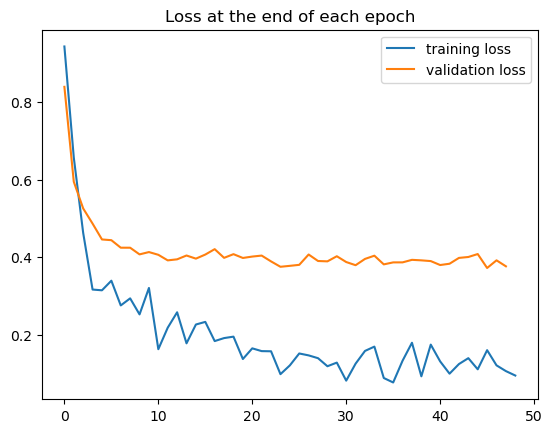

In [197]:
# Plot Losses per epoch
plt.plot([t.cpu().detach().numpy() for t in train_loss_list], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_list], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

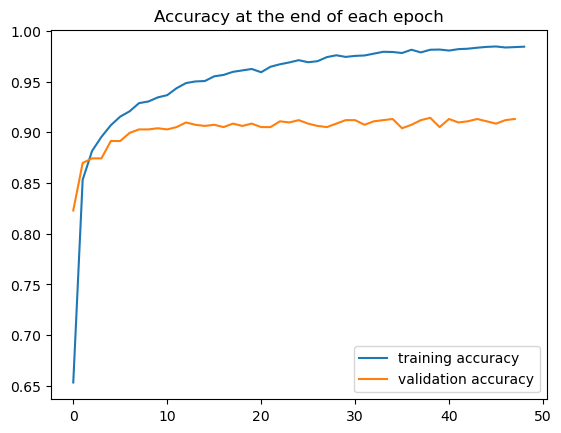

In [198]:
# Plot accuracy per epoch
plt.plot([t.cpu() / train_data_len for t in train_corr_list], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_list], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [199]:
# How many accurate predictions were made per epoch for both train and val sets
print("Train Correct:")
print("---------------------------------")
print(train_corr_list)
print("---------------------------------")
print("Out of", train_data_len, "train set size")
print("\t")
print("Validation Correct:")
print("---------------------------------")
print(val_corr_list)
print("---------------------------------")
print("Out of", val_data_len, "train set size")

Train Correct:
---------------------------------
[tensor(3238, device='cuda:0'), tensor(4229, device='cuda:0'), tensor(4370, device='cuda:0'), tensor(4439, device='cuda:0'), tensor(4496, device='cuda:0'), tensor(4538, device='cuda:0'), tensor(4564, device='cuda:0'), tensor(4604, device='cuda:0'), tensor(4612, device='cuda:0'), tensor(4632, device='cuda:0'), tensor(4643, device='cuda:0'), tensor(4677, device='cuda:0'), tensor(4702, device='cuda:0'), tensor(4710, device='cuda:0'), tensor(4712, device='cuda:0'), tensor(4735, device='cuda:0'), tensor(4742, device='cuda:0'), tensor(4757, device='cuda:0'), tensor(4764, device='cuda:0'), tensor(4771, device='cuda:0'), tensor(4755, device='cuda:0'), tensor(4782, device='cuda:0'), tensor(4794, device='cuda:0'), tensor(4803, device='cuda:0'), tensor(4814, device='cuda:0'), tensor(4804, device='cuda:0'), tensor(4809, device='cuda:0'), tensor(4829, device='cuda:0'), tensor(4838, device='cuda:0'), tensor(4830, device='cuda:0'), tensor(4835, device=

## Load saved model (AdamW)

In [301]:
AdamW_best = models.shufflenet_v2_x2_0(pretrained=True)
AdamW_best.fc = nn.Linear(2048, 11)
AdamW_best.load_state_dict(torch.load('ShuffleNetAdamW.pt'))

<All keys matched successfully>

In [302]:
move_model_and_optimizer_to_gpu(AdamW_best, optimizer)

## Test the model (AdamW)

In [303]:
test_corr_list = []

# Call the test model function
acc_AdamW = test_model(AdamW_best, criterion, test_loader, test_corr_list)

In [92]:
# img size 224x224

# Check how many correct predictions were made
print("Test Correct:", test_corr_list, "out of", test_data_len, "test set size")
# Print model accuracy on the test set
print("Test Accuracy:", acc_AdamW, "%")

Test Correct: [tensor(926, device='cuda:0')] out of 1030 test set size
Test Accuracy: 89.903 %


In [203]:
# img size 384x384

# Check how many correct predictions were made
print("Test Correct:", test_corr_list, "out of", test_data_len, "test set size")
# Print model accuracy on the test set
print("Test Accuracy:", acc_AdamW, "%")

Test Correct: [tensor(941, device='cuda:0')] out of 1030 test set size
Test Accuracy: 91.359 %


In [204]:
# Individual model class performance on the test set
class_performance(AdamW_best, test_loader)

Accuracy for class: dew        94.68 %
Accuracy for class: fogsmog    94.78 %
Accuracy for class: frost      80.95 %
Accuracy for class: glaze      82.88 %
Accuracy for class: hail       98.82 %
Accuracy for class: lightning  96.15 %
Accuracy for class: rain       95.06 %
Accuracy for class: rainbow    95.24 %
Accuracy for class: rime       90.80 %
Accuracy for class: sandstorm  95.79 %
Accuracy for class: snow       82.83 %


## Confusion Matrix Metrics (AdamW)

---------------------------------
Individual Class Metrics:
---------------------------------
	
Class: 0
---------------------------------
True Positive (TP): 89
True Negative (TN): 930
False Positive (FP): 6
False Negative (FN): 5
Precision: 0.937
Recall: 0.947
F1 Score: 0.942
	
Class: 1
---------------------------------
True Positive (TP): 127
True Negative (TN): 889
False Positive (FP): 7
False Negative (FN): 7
Precision: 0.948
Recall: 0.948
F1 Score: 0.948
	
Class: 2
---------------------------------
True Positive (TP): 51
True Negative (TN): 951
False Positive (FP): 16
False Negative (FN): 12
Precision: 0.761
Recall: 0.81
F1 Score: 0.785
	
Class: 3
---------------------------------
True Positive (TP): 92
True Negative (TN): 902
False Positive (FP): 17
False Negative (FN): 19
Precision: 0.844
Recall: 0.829
F1 Score: 0.836
	
Class: 4
---------------------------------
True Positive (TP): 84
True Negative (TN): 944
False Positive (FP): 1
False Negative (FN): 1
Precision: 0.988
Recall:

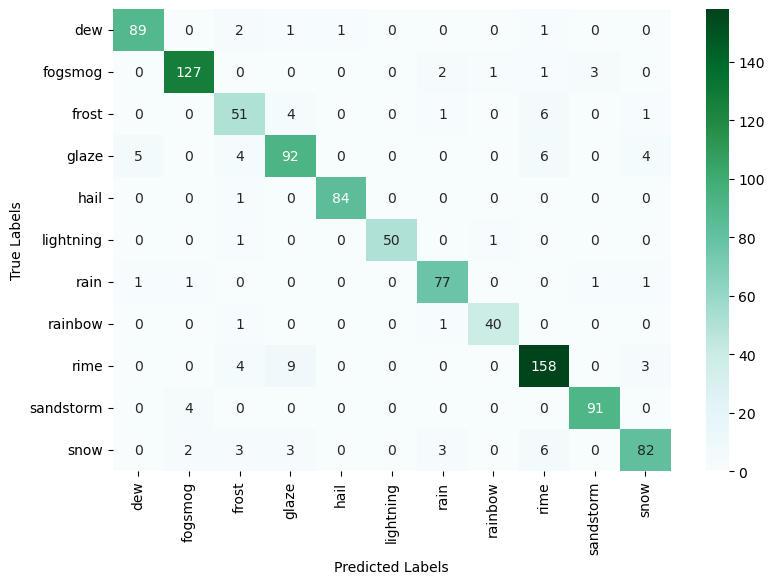

In [205]:
# Call the confusion matrix function
show_confusion_matrix(AdamW_best)

# Lion optimizer

## Set the best hyperparameters (Lion)

In [360]:
# train_loader, val_loader, test_loader, criterion, optimizer = set_best_hyperparameters(
#     ShuffleNet, best_batch_size, best_lr, best_l1, best_l2, "AdamW")

train_loader, val_loader, test_loader, criterion, optimizer = set_best_hyperparameters(
    ShuffleNet, 128, 0.001, 0.001, 0.001, "Lion")

best_l1 = 0.001

## Training model (Lion) img size 224x224

In [114]:
# Define lists to append train and val losses and accuracy per epoch
train_loss_list = []
train_corr_list = []
val_loss_list = []
val_corr_list = []

# Call the training and validation function
train_and_val_model(ShuffleNet, criterion, optimizer, best_l1, train_loader,
                    val_loader, "ShuffleNet",train_loss_list, train_corr_list,
                    val_loss_list, val_corr_list, "Lion")

Epoch: 1 Train Loss: 0.517 Train Accuracy: 68.449 %
Epoch: 1 Validation Loss: 0.583 Validation Accuracy: 84.457 %
Best Validation Accuracy: 84.457 % counter: 0
	
Epoch: 2 Train Loss: 0.389 Train Accuracy: 87.351 %
Epoch: 2 Validation Loss: 0.488 Validation Accuracy: 88.229 %
Best Validation Accuracy: 88.229 % counter: 0
	
Epoch: 3 Train Loss: 0.28 Train Accuracy: 91.063 %
Epoch: 3 Validation Loss: 0.499 Validation Accuracy: 88.914 %
Best Validation Accuracy: 88.914 % counter: 0
	
Epoch: 4 Train Loss: 0.3 Train Accuracy: 93.101 %
Epoch: 4 Validation Loss: 0.522 Validation Accuracy: 88.229 %
Best Validation Accuracy: 88.914 % counter: 1
	
Epoch: 5 Train Loss: 0.318 Train Accuracy: 93.161 %
Epoch: 5 Validation Loss: 0.562 Validation Accuracy: 89.143 %
Best Validation Accuracy: 89.143 % counter: 0
	
Epoch: 6 Train Loss: 0.215 Train Accuracy: 92.98 %
Epoch: 6 Validation Loss: 0.592 Validation Accuracy: 89.143 %
Best Validation Accuracy: 89.143 % counter: 1
	
Epoch: 7 Train Loss: 0.328 Train

## Training model (Lion) img size 384x384

In [222]:
# Define lists to append train and val losses and accuracy per epoch
train_loss_list = []
train_corr_list = []
val_loss_list = []
val_corr_list = []

# Call the training and validation function
train_and_val_model(ShuffleNet, criterion, optimizer, best_l1, train_loader,
                    val_loader, "ShuffleNet",train_loss_list, train_corr_list,
                    val_loss_list, val_corr_list, "Lion")

Epoch: 1 Train Loss: 0.691 Train Accuracy: 66.774 %
Epoch: 1 Validation Loss: 0.607 Validation Accuracy: 85.486 %
Best Validation Accuracy: 85.486 % counter: 0
	
Epoch: 2 Train Loss: 0.24 Train Accuracy: 87.109 %
Epoch: 2 Validation Loss: 0.472 Validation Accuracy: 88.229 %
Best Validation Accuracy: 88.229 % counter: 0
	
Epoch: 3 Train Loss: 0.439 Train Accuracy: 89.732 %
Epoch: 3 Validation Loss: 0.428 Validation Accuracy: 89.143 %
Best Validation Accuracy: 89.143 % counter: 0
	
Epoch: 4 Train Loss: 0.177 Train Accuracy: 92.132 %
Epoch: 4 Validation Loss: 0.419 Validation Accuracy: 89.6 %
Best Validation Accuracy: 89.6 % counter: 0
	
Epoch: 5 Train Loss: 0.347 Train Accuracy: 92.798 %
Epoch: 5 Validation Loss: 0.421 Validation Accuracy: 89.486 %
Best Validation Accuracy: 89.6 % counter: 1
	
Epoch: 6 Train Loss: 0.272 Train Accuracy: 92.959 %
Epoch: 6 Validation Loss: 0.449 Validation Accuracy: 89.829 %
Best Validation Accuracy: 89.829 % counter: 0
	
Epoch: 7 Train Loss: 0.282 Train Ac

## Evaluate model (Lion), Image size 384 x 384

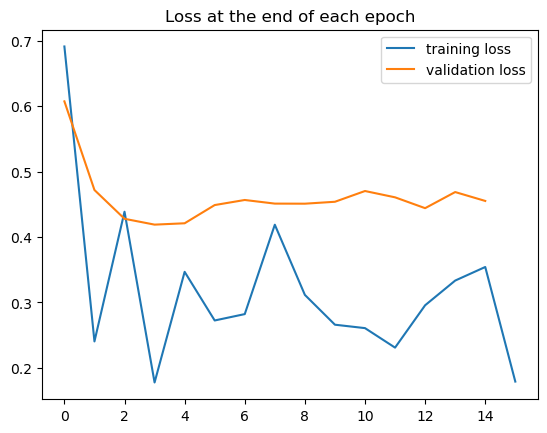

In [223]:
# Plot Losses per epoch
plt.plot([t.cpu().detach().numpy() for t in train_loss_list], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_list], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

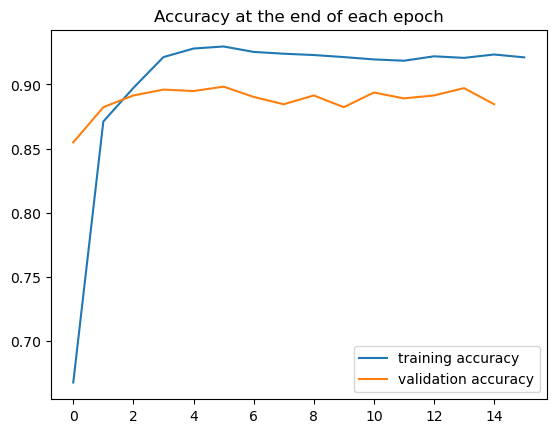

In [224]:
# Plot accuracy per epoch
plt.plot([t.cpu() / train_data_len for t in train_corr_list], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_list], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [225]:
# How many accurate predictions were made per epoch for both train and val sets
print("Train Correct:")
print("---------------------------------")
print(train_corr_list)
print("---------------------------------")
print("Out of", train_data_len, "train set size")
print("\t")
print("Validation Correct:")
print("---------------------------------")
print(val_corr_list)
print("---------------------------------")
print("Out of", val_data_len, "train set size")

Train Correct:
---------------------------------
[tensor(3310, device='cuda:0'), tensor(4318, device='cuda:0'), tensor(4448, device='cuda:0'), tensor(4567, device='cuda:0'), tensor(4600, device='cuda:0'), tensor(4608, device='cuda:0'), tensor(4587, device='cuda:0'), tensor(4580, device='cuda:0'), tensor(4575, device='cuda:0'), tensor(4567, device='cuda:0'), tensor(4558, device='cuda:0'), tensor(4553, device='cuda:0'), tensor(4570, device='cuda:0'), tensor(4564, device='cuda:0'), tensor(4577, device='cuda:0'), tensor(4566, device='cuda:0')]
---------------------------------
Out of 4957 train set size
	
Validation Correct:
---------------------------------
[tensor(748, device='cuda:0'), tensor(772, device='cuda:0'), tensor(780, device='cuda:0'), tensor(784, device='cuda:0'), tensor(783, device='cuda:0'), tensor(786, device='cuda:0'), tensor(779, device='cuda:0'), tensor(774, device='cuda:0'), tensor(780, device='cuda:0'), tensor(772, device='cuda:0'), tensor(782, device='cuda:0'), tensor

## Load saved model (Lion)

In [361]:
Lion_best = models.shufflenet_v2_x2_0(pretrained=True)
Lion_best.fc = nn.Linear(2048, 11)
Lion_best.load_state_dict(torch.load('ShuffleNetLion.pt'))

<All keys matched successfully>

In [362]:
move_model_and_optimizer_to_gpu(Lion_best, optimizer)

## Test the model (Lion)

In [363]:
test_corr_list = []

# Call the test model function
acc_Lion = test_model(Lion_best, criterion, test_loader, test_corr_list)

In [121]:
# Image size 224x224

# Check how many correct predictions were made
print("Test Correct:", test_corr_list, "out of", test_data_len, "test set size")
# Print model accuracy on the test set
print("Test Accuracy:", acc_Lion, "%")

Test Correct: [tensor(920, device='cuda:0')] out of 1030 test set size
Test Accuracy: 89.32 %


In [229]:
# Image size 384x384

# Check how many correct predictions were made
print("Test Correct:", test_corr_list, "out of", test_data_len, "test set size")
# Print model accuracy on the test set
print("Test Accuracy:", acc_Lion, "%")

Test Correct: [tensor(927, device='cuda:0')] out of 1030 test set size
Test Accuracy: 90.0 %


In [365]:
# Individual model class performance on the test set
class_performance(Lion_best, test_loader)

Accuracy for class: dew        94.68 %
Accuracy for class: fogsmog    90.30 %
Accuracy for class: frost      74.60 %
Accuracy for class: glaze      81.98 %
Accuracy for class: hail       97.65 %
Accuracy for class: lightning  96.15 %
Accuracy for class: rain       93.83 %
Accuracy for class: rainbow    90.48 %
Accuracy for class: rime       90.23 %
Accuracy for class: sandstorm  96.84 %
Accuracy for class: snow       83.84 %


## Confusion Matrix Metrics (Lion)

---------------------------------
Individual Class Metrics:
---------------------------------
	
Class: 0
---------------------------------
True Positive (TP): 89
True Negative (TN): 931
False Positive (FP): 5
False Negative (FN): 5
Precision: 0.947
Recall: 0.947
F1 Score: 0.947
	
Class: 1
---------------------------------
True Positive (TP): 121
True Negative (TN): 891
False Positive (FP): 5
False Negative (FN): 13
Precision: 0.96
Recall: 0.903
F1 Score: 0.931
	
Class: 2
---------------------------------
True Positive (TP): 47
True Negative (TN): 951
False Positive (FP): 16
False Negative (FN): 16
Precision: 0.746
Recall: 0.746
F1 Score: 0.746
	
Class: 3
---------------------------------
True Positive (TP): 91
True Negative (TN): 900
False Positive (FP): 19
False Negative (FN): 20
Precision: 0.827
Recall: 0.82
F1 Score: 0.824
	
Class: 4
---------------------------------
True Positive (TP): 83
True Negative (TN): 944
False Positive (FP): 1
False Negative (FN): 2
Precision: 0.988
Recall:

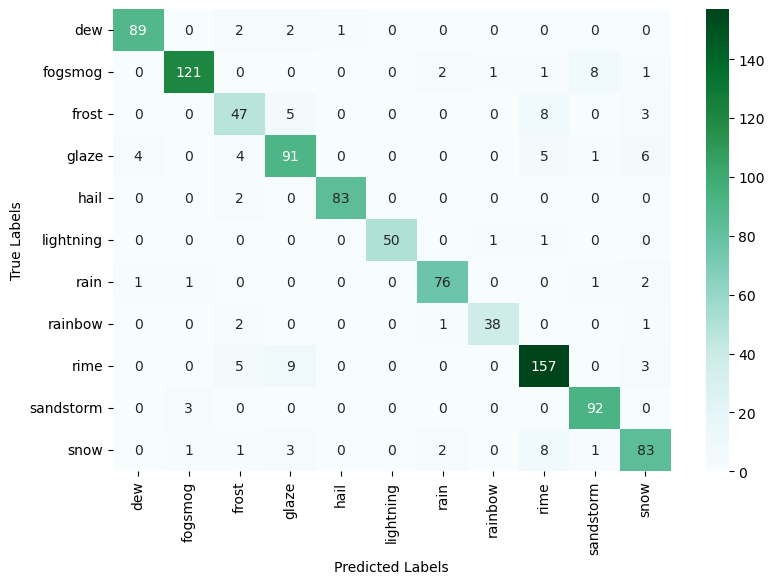

In [366]:
# Call the confusion matrix function
show_confusion_matrix(Lion_best)

# SGD optimizer

## Set the best hyperparameters (SGD)

In [367]:
# train_loader, val_loader, test_loader, criterion, optimizer = set_best_hyperparameters(
#     ShuffleNet, best_batch_size, best_lr, best_l1, best_l2, "AdamW")

train_loader, val_loader, test_loader, criterion, optimizer = set_best_hyperparameters(
    ShuffleNet, 64, 0.01, 0.0001, 0.0001, "SGD")

best_l1 = 0.0001

## Training model (SGD), image size 224 x 224

In [44]:
# Define lists to append train and val losses and accuracy per epoch
train_loss_list = []
train_corr_list = []
val_loss_list = []
val_corr_list = []

# Call the training and validation function
train_and_val_model(ShuffleNet, criterion, optimizer, best_l1, train_loader,
                    val_loader, "ShuffleNet",train_loss_list, train_corr_list,
                    val_loss_list, val_corr_list, "SGD")

Epoch: 1 Train Loss: 1.412 Train Accuracy: 52.33 %
Epoch: 1 Validation Loss: 1.358 Validation Accuracy: 67.2 %
Best Validation Accuracy: 67.2 % counter: 0
	
Epoch: 2 Train Loss: 1.293 Train Accuracy: 73.553 %
Epoch: 2 Validation Loss: 1.018 Validation Accuracy: 76.0 %
Best Validation Accuracy: 76.0 % counter: 0
	
Epoch: 3 Train Loss: 1.017 Train Accuracy: 80.23 %
Epoch: 3 Validation Loss: 0.853 Validation Accuracy: 80.457 %
Best Validation Accuracy: 80.457 % counter: 0
	
Epoch: 4 Train Loss: 0.887 Train Accuracy: 82.55 %
Epoch: 4 Validation Loss: 0.765 Validation Accuracy: 81.143 %
Best Validation Accuracy: 81.143 % counter: 0
	
Epoch: 5 Train Loss: 0.618 Train Accuracy: 84.144 %
Epoch: 5 Validation Loss: 0.697 Validation Accuracy: 82.286 %
Best Validation Accuracy: 82.286 % counter: 0
	
Epoch: 6 Train Loss: 0.843 Train Accuracy: 84.648 %
Epoch: 6 Validation Loss: 0.646 Validation Accuracy: 83.314 %
Best Validation Accuracy: 83.314 % counter: 0
	
Epoch: 7 Train Loss: 0.681 Train Accura

## Training model (SGD), image size 384 x 384

In [245]:
# Define lists to append train and val losses and accuracy per epoch
train_loss_list = []
train_corr_list = []
val_loss_list = []
val_corr_list = []

# Call the training and validation function
train_and_val_model(ShuffleNet, criterion, optimizer, best_l1, train_loader,
                    val_loader, "ShuffleNet",train_loss_list, train_corr_list,
                    val_loss_list, val_corr_list, "SGD")

Epoch: 1 Train Loss: 1.751 Train Accuracy: 46.076 %
Epoch: 1 Validation Loss: 1.554 Validation Accuracy: 62.743 %
Best Validation Accuracy: 62.743 % counter: 0
	
Epoch: 2 Train Loss: 1.135 Train Accuracy: 70.305 %
Epoch: 2 Validation Loss: 1.218 Validation Accuracy: 74.514 %
Best Validation Accuracy: 74.514 % counter: 0
	
Epoch: 3 Train Loss: 1.105 Train Accuracy: 77.628 %
Epoch: 3 Validation Loss: 1.02 Validation Accuracy: 79.086 %
Best Validation Accuracy: 79.086 % counter: 0
	
Epoch: 4 Train Loss: 0.926 Train Accuracy: 81.077 %
Epoch: 4 Validation Loss: 0.887 Validation Accuracy: 82.057 %
Best Validation Accuracy: 82.057 % counter: 0
	
Epoch: 5 Train Loss: 0.941 Train Accuracy: 82.55 %
Epoch: 5 Validation Loss: 0.809 Validation Accuracy: 82.057 %
Best Validation Accuracy: 82.057 % counter: 1
	
Epoch: 6 Train Loss: 0.759 Train Accuracy: 84.466 %
Epoch: 6 Validation Loss: 0.747 Validation Accuracy: 84.114 %
Best Validation Accuracy: 84.114 % counter: 0
	
Epoch: 7 Train Loss: 0.652 Tra

Epoch: 52 Train Loss: 0.89 Train Accuracy: 91.366 %
Epoch: 52 Validation Loss: 0.492 Validation Accuracy: 89.029 %
Best Validation Accuracy: 89.6 % counter: 5
	
Epoch: 53 Train Loss: 0.477 Train Accuracy: 91.951 %
Epoch: 53 Validation Loss: 0.48 Validation Accuracy: 89.6 %
Best Validation Accuracy: 89.6 % counter: 6
	
Epoch: 54 Train Loss: 0.448 Train Accuracy: 91.91 %
Epoch: 54 Validation Loss: 0.473 Validation Accuracy: 89.029 %
Best Validation Accuracy: 89.6 % counter: 7
	
Epoch: 55 Train Loss: 0.249 Train Accuracy: 91.971 %
Epoch: 55 Validation Loss: 0.474 Validation Accuracy: 88.914 %
Best Validation Accuracy: 89.6 % counter: 8
	
Epoch: 56 Train Loss: 0.42 Train Accuracy: 91.83 %
Epoch: 56 Validation Loss: 0.461 Validation Accuracy: 88.914 %
Best Validation Accuracy: 89.6 % counter: 9
	
Epoch: 57 Train Loss: 0.31 Train Accuracy: 91.971 %
Epoch: 57 Validation Loss: 0.475 Validation Accuracy: 89.371 %
Early stopping triggered. Training stopped.


Duration: 9558.3 seconds


## Evaluate model (SGD), Image size 384 x 3

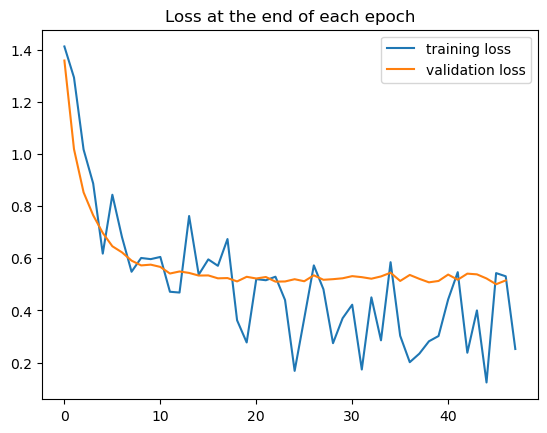

In [45]:
# Image size 224x224

# Plot Losses per epoch
plt.plot([t.cpu().detach().numpy() for t in train_loss_list], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_list], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

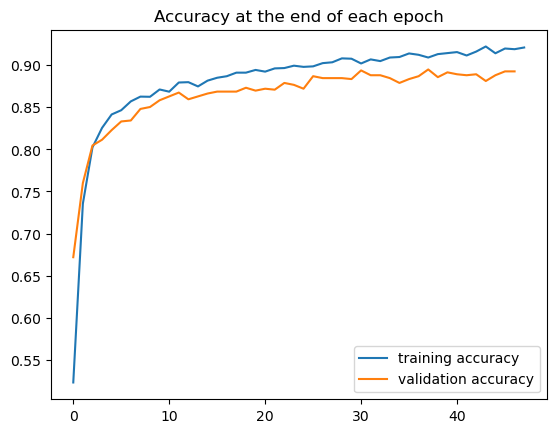

In [46]:
# Image size 224x224

# Plot accuracy per epoch
plt.plot([t.cpu() / train_data_len for t in train_corr_list], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_list], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

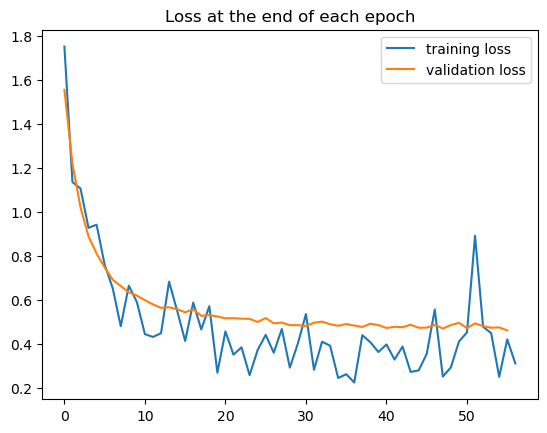

In [246]:
# Image size 384x384

# Plot Losses per epoch
plt.plot([t.cpu().detach().numpy() for t in train_loss_list], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_list], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

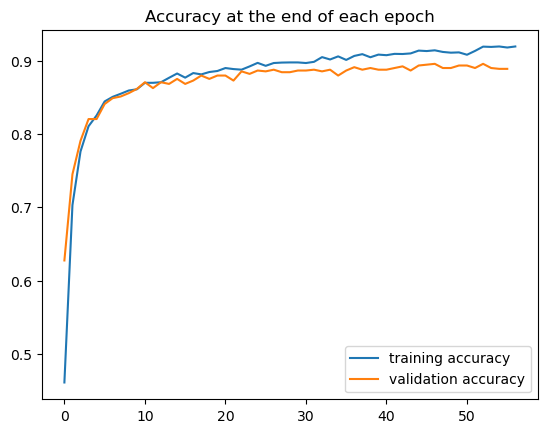

In [247]:
# Image size 384x384

# Plot accuracy per epoch
plt.plot([t.cpu() / train_data_len for t in train_corr_list], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_list], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [47]:
# How many accurate predictions were made per epoch for both train and val sets
print("Train Correct:")
print("---------------------------------")
print(train_corr_list)
print("---------------------------------")
print("Out of", train_data_len, "train set size")
print("\t")
print("Validation Correct:")
print("---------------------------------")
print(val_corr_list)
print("---------------------------------")
print("Out of", val_data_len, "train set size")

Train Correct:
---------------------------------
[tensor(2594, device='cuda:0'), tensor(3646, device='cuda:0'), tensor(3977, device='cuda:0'), tensor(4092, device='cuda:0'), tensor(4171, device='cuda:0'), tensor(4196, device='cuda:0'), tensor(4248, device='cuda:0'), tensor(4276, device='cuda:0'), tensor(4275, device='cuda:0'), tensor(4318, device='cuda:0'), tensor(4305, device='cuda:0'), tensor(4359, device='cuda:0'), tensor(4361, device='cuda:0'), tensor(4336, device='cuda:0'), tensor(4370, device='cuda:0'), tensor(4387, device='cuda:0'), tensor(4396, device='cuda:0'), tensor(4417, device='cuda:0'), tensor(4417, device='cuda:0'), tensor(4433, device='cuda:0'), tensor(4423, device='cuda:0'), tensor(4442, device='cuda:0'), tensor(4444, device='cuda:0'), tensor(4458, device='cuda:0'), tensor(4451, device='cuda:0'), tensor(4454, device='cuda:0'), tensor(4473, device='cuda:0'), tensor(4478, device='cuda:0'), tensor(4501, device='cuda:0'), tensor(4499, device='cuda:0'), tensor(4471, device=

## Load saved model (SGD)

In [368]:
SGD_best = models.shufflenet_v2_x2_0(pretrained=True)
SGD_best.fc = nn.Linear(2048, 11)
SGD_best.load_state_dict(torch.load('ShuffleNetSGD.pt'))

<All keys matched successfully>

In [369]:
move_model_and_optimizer_to_gpu(SGD_best, optimizer)

## Test the model (SGD)

In [370]:
test_corr_list = []

# Call the test model function
acc_SGD = test_model(SGD_best, criterion, test_loader, test_corr_list)

In [51]:
# Image size 224 x 224

# Check how many correct predictions were made
print("Test Correct:", test_corr_list, "out of", test_data_len, "test set size")
# Print model accuracy on the test set
print("Test Accuracy:", acc_SGD, "%")

Test Correct: [tensor(918, device='cuda:0')] out of 1030 test set size
Test Accuracy: 89.126 %


In [371]:
# Image size 384 x 384

# Check how many correct predictions were made
print("Test Correct:", test_corr_list, "out of", test_data_len, "test set size")
# Print model accuracy on the test set
print("Test Accuracy:", acc_SGD, "%")

Test Correct: [tensor(917, device='cuda:0')] out of 1030 test set size
Test Accuracy: 89.029 %


In [372]:
# Individual model class performance on the test set
class_performance(SGD_best, test_loader)

Accuracy for class: dew        93.62 %
Accuracy for class: fogsmog    94.03 %
Accuracy for class: frost      73.02 %
Accuracy for class: glaze      78.38 %
Accuracy for class: hail       97.65 %
Accuracy for class: lightning  96.15 %
Accuracy for class: rain       88.89 %
Accuracy for class: rainbow    92.86 %
Accuracy for class: rime       91.95 %
Accuracy for class: sandstorm  93.68 %
Accuracy for class: snow       77.78 %


## Confusion Matrix Metrics (SGD)

---------------------------------
Individual Class Metrics:
---------------------------------
	
Class: 0
---------------------------------
True Positive (TP): 88
True Negative (TN): 930
False Positive (FP): 6
False Negative (FN): 6
Precision: 0.936
Recall: 0.936
F1 Score: 0.936
	
Class: 1
---------------------------------
True Positive (TP): 126
True Negative (TN): 881
False Positive (FP): 15
False Negative (FN): 8
Precision: 0.894
Recall: 0.94
F1 Score: 0.916
	
Class: 2
---------------------------------
True Positive (TP): 46
True Negative (TN): 954
False Positive (FP): 13
False Negative (FN): 17
Precision: 0.78
Recall: 0.73
F1 Score: 0.754
	
Class: 3
---------------------------------
True Positive (TP): 87
True Negative (TN): 897
False Positive (FP): 22
False Negative (FN): 24
Precision: 0.798
Recall: 0.784
F1 Score: 0.791
	
Class: 4
---------------------------------
True Positive (TP): 83
True Negative (TN): 942
False Positive (FP): 3
False Negative (FN): 2
Precision: 0.965
Recall: 

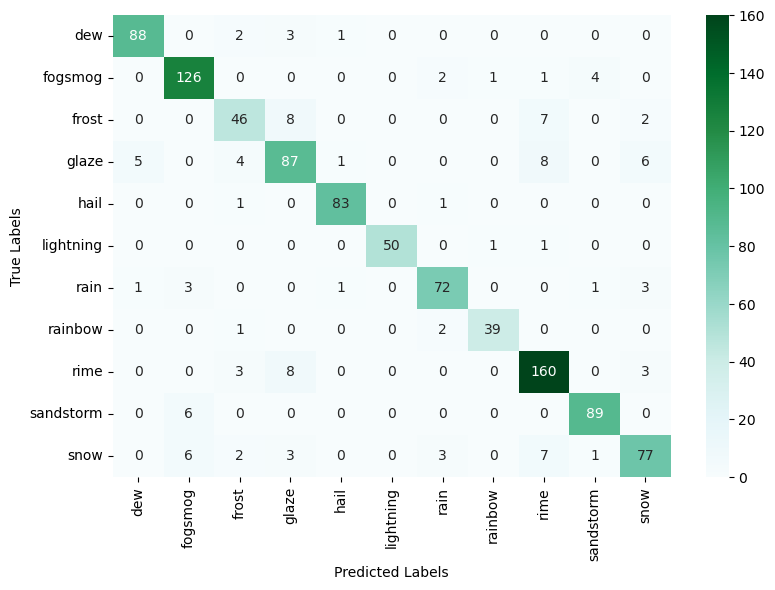

In [373]:
# Call the confusion matrix function
show_confusion_matrix(SGD_best)

## Open a custom image and use the models for prediction

Custom image size: torch.Size([3, 384, 384])
	


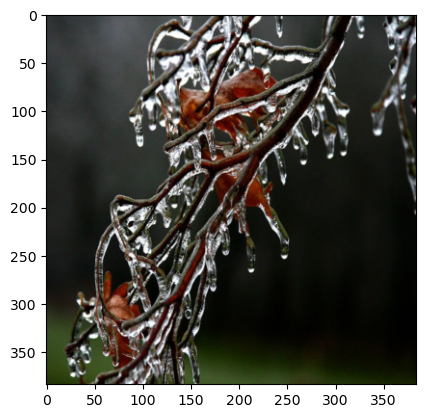

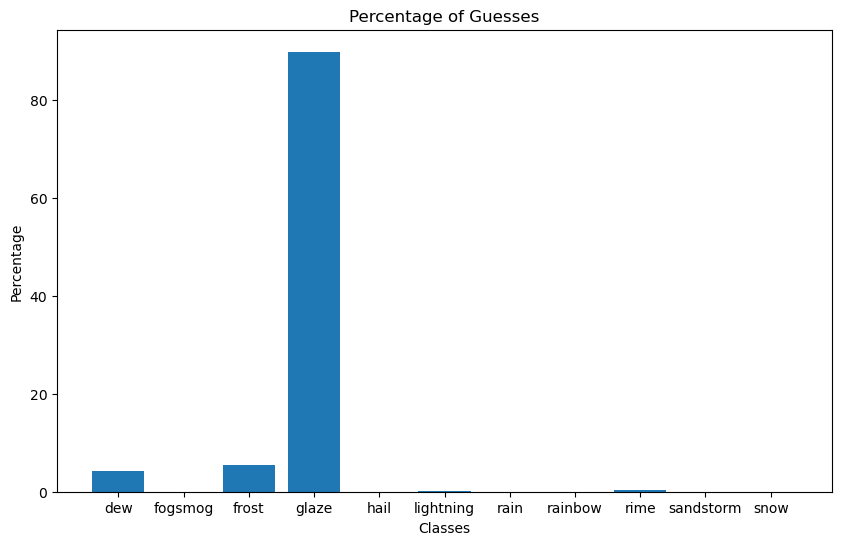

ShuffleNet AdamW model prediction: glaze
	
Percentage of Guesses:
dew        4.18%
fogsmog    0.01%
frost      5.40%
glaze      89.77%
hail       0.01%
lightning  0.08%
rain       0.04%
rainbow    0.02%
rime       0.42%
sandstorm  0.03%
snow       0.04%
	


In [374]:
custom_img_prediction('9.jpg', AdamW_best, 'ShuffleNet AdamW')

Custom image size: torch.Size([3, 384, 384])
	


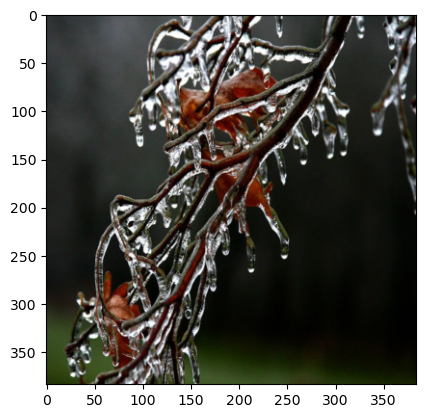

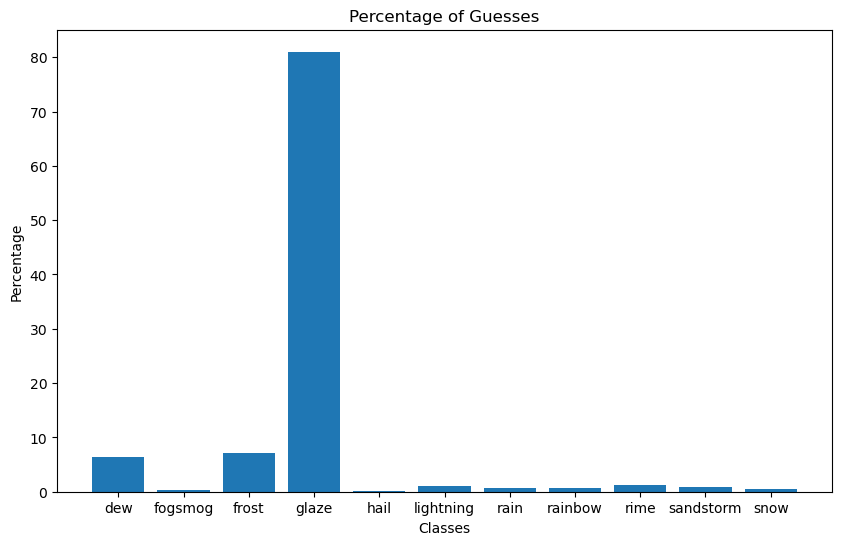

ShuffleNet Lion model prediction: glaze
	
Percentage of Guesses:
dew        6.47%
fogsmog    0.26%
frost      7.14%
glaze      81.02%
hail       0.17%
lightning  1.08%
rain       0.63%
rainbow    0.69%
rime       1.21%
sandstorm  0.87%
snow       0.45%
	


In [375]:
custom_img_prediction('9.jpg', Lion_best, 'ShuffleNet Lion')

Custom image size: torch.Size([3, 384, 384])
	


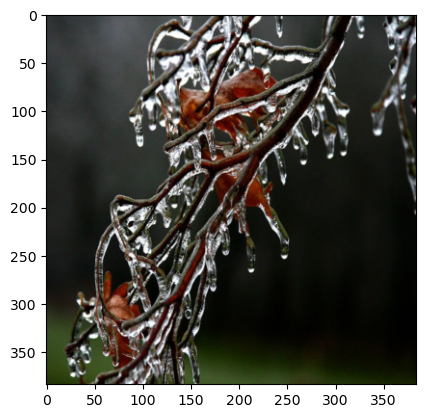

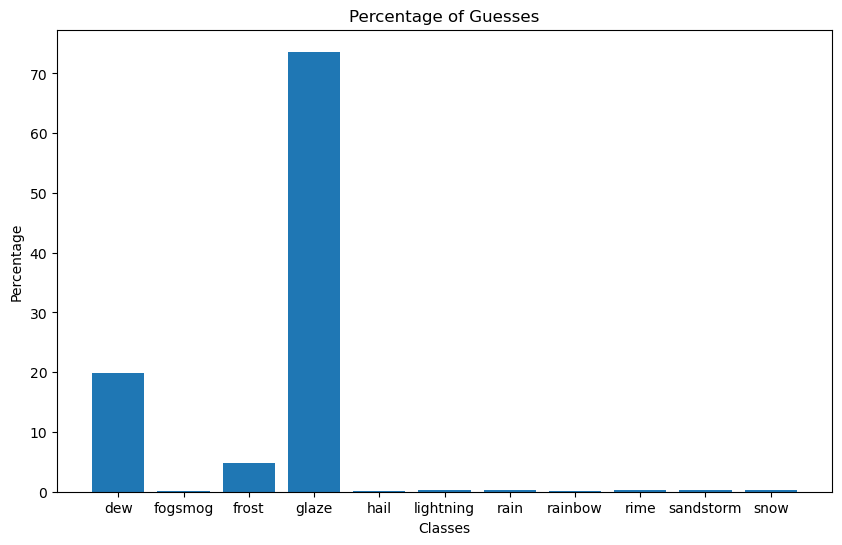

ShuffleNet SGD model prediction: glaze
	
Percentage of Guesses:
dew        19.88%
fogsmog    0.17%
frost      4.75%
glaze      73.64%
hail       0.15%
lightning  0.29%
rain       0.24%
rainbow    0.16%
rime       0.25%
sandstorm  0.26%
snow       0.21%
	


In [376]:
custom_img_prediction('9.jpg', SGD_best, 'ShuffleNet SGD')